In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (confusion_matrix, classification_report, precision_score, 
                             recall_score, f1_score, precision_recall_curve, roc_curve)


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

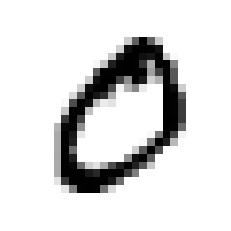

0


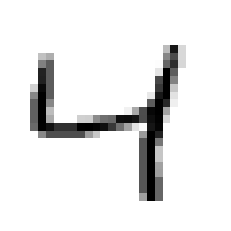

4


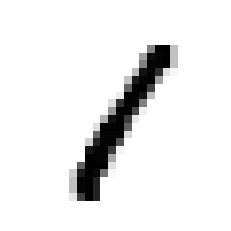

1


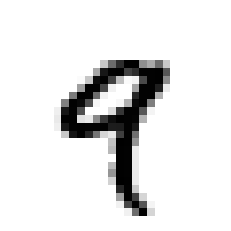

9


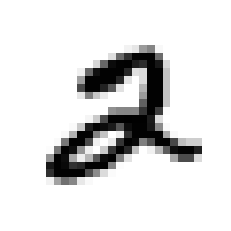

2


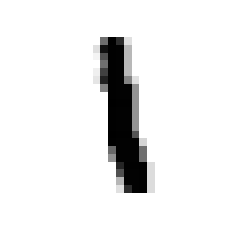

1


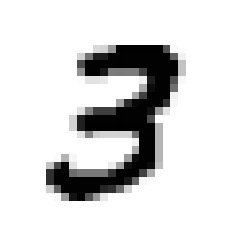

3


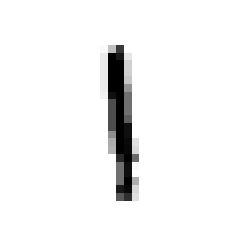

1


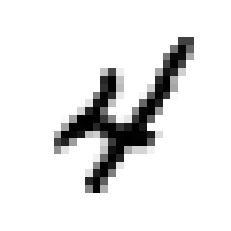

4


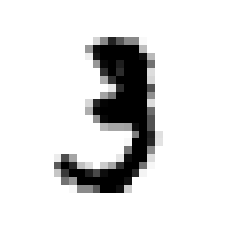

3


In [5]:
# Show a few digits
for i in range(1,11):
    digit = X[i]
    digit_image = digit.reshape(28,28)

    plt.imshow(digit_image, cmap='binary')
    plt.axis('off')
    plt.show()
    print(y[i])

In [6]:
# Cast label as an int
y = y.astype(np.uint8)

# Create train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[:60000]

# Try to identify only one digit - turn this into binanry classificaiton problem
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

some_digit= X[0]   # This digit is a five

# try Stochastic GD because it cna handle large datasets
clf_sgd = SGDClassifier().fit(X_train, y_train_5)
y_pred = clf_sgd.predict([some_digit])
y_pred 

array([False])

In [7]:
# Evaluate Performance
cross_val_score(clf_sgd, X_train, y_train_5, cv=5, scoring='accuracy')

array([0.95191667, 0.963     , 0.95208333, 0.9535    , 0.96541667])

In [8]:
# Now try a less smart model to predict everything that is not a 5.
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

clf_never_5 = Never5Classifier()
cross_val_score(clf_never_5, X_train, y_train_5, cv=5, scoring='accuracy')
# 90% is right because 10% of the images are 5's but this doesnt' tell us much anyways

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

In [9]:
y_train_pred = cross_val_predict(clf_sgd, X_train, y_train_5, cv=5)

In [10]:
# Examine Performance
print(classification_report(y_train_5, y_train_pred))
print(confusion_matrix(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98     54579
        True       0.75      0.78      0.77      5421

    accuracy                           0.96     60000
   macro avg       0.86      0.88      0.87     60000
weighted avg       0.96      0.96      0.96     60000

[[53176  1403]
 [ 1189  4232]]


In [11]:
# Consistent with what is above
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.7510204081632653
0.7806677734735289
0.7655571635311144


In [12]:
# Precision/Recall Tradeoff
# Check the threshold value used in determining the cutoff
y_scores = clf_sgd.decision_function([some_digit])
y_scores

array([-2865.5731764])

In [13]:
# Example of threshold
threshold = 3411 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [14]:
# To decide which threshold to use use cv prediction with decision function for the method
y_scores = cross_val_predict(clf_sgd, X_train, y_train_5, cv=5, method='decision_function')
y_scores

array([ 10220.98146548, -12999.94552233, -27549.66614315, ...,
         6902.21578024,  -5263.5937757 ,  -2867.48480319])

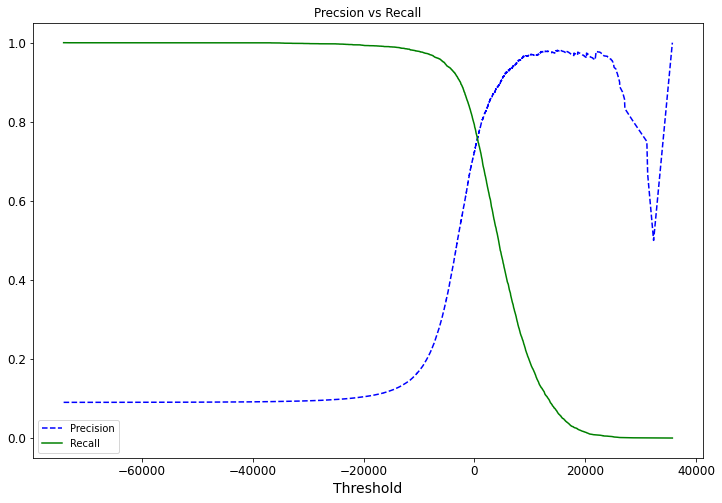

In [15]:
# Plot precions vs recall curves for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """ Plots precision vs recall for all thresholds"""
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1],'g-',label='Recall')
    plt.legend()
    plt.title('Precsion vs Recall')
    plt.xlabel('Threshold')
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

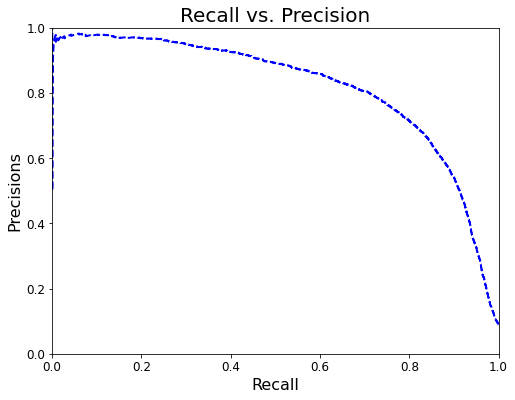

In [16]:
def plot_precision_vs_recall(precisions, recalls):
    """ Plot Precision vs. Recall """
    plt.figure(figsize=(8,6))
    plt.plot(recalls, precisions, 'b--', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precisions', fontsize=16)
    plt.axis([0,1,0,1])
    plt.title('Recall vs. Precision', fontsize=20)

plot_precision_vs_recall(precisions, recalls)
    

In [17]:
# Pick the threshold value that gives 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
print(f"Threshold to use for 90% precision: " + np.str(threshold_90_precision))

Threshold to use for 90% precision: 4707.730056142879


In [18]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

# Check Precision and Recall
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.4724220623501199

## ROC Curve

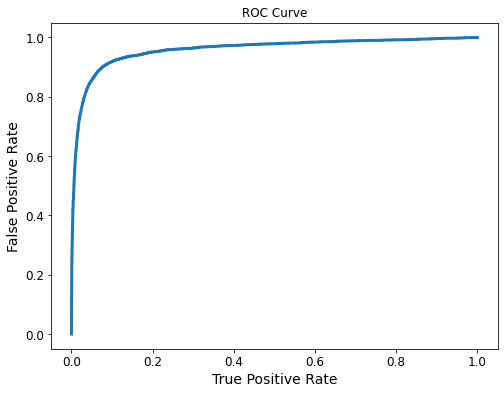

In [19]:
#Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    """ Plot the ROC curve. """
    plt.figure(figsize=(8,6))
    plt.plot(fpr,tpr, linewidth=3)
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

plot_roc_curve(fpr,tpr)

In [20]:
# Train a Random Forest Classifier against the data
clf_forest = RandomForestClassifier()
y_probas_forest = cross_val_predict(clf_forest,X_train, y_train_5, cv=3, method='predict_proba')

In [21]:
# Positive Class probability
y_scores_forest = y_probas_forest[:,1]
y_scores_forest

array([0.81, 0.02, 0.02, ..., 0.98, 0.13, 0.03])

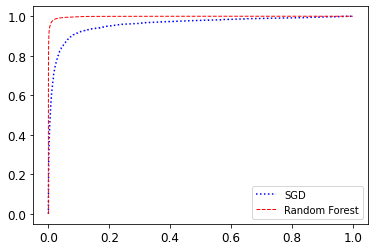

In [22]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr,'b:', label='SGD')
plt.plot(fpr_forest,tpr_forest, 'r--', linewidth=1, label='Random Forest')
plt.legend()

In [23]:
# Random Forest has larger AUC - Better Model

### SGD Model on entire dataset

In [24]:
# Check the number of times each digit appears in the training data
pd.DataFrame(y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [25]:
# Scale the data to see if can get an improvement in accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(clf_sgd, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished


array([0.9039, 0.8947, 0.9104])

In [26]:
y_pred = cross_val_predict(clf_sgd, X_train_scaled, y_train, cv=3, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished


<AxesSubplot:>

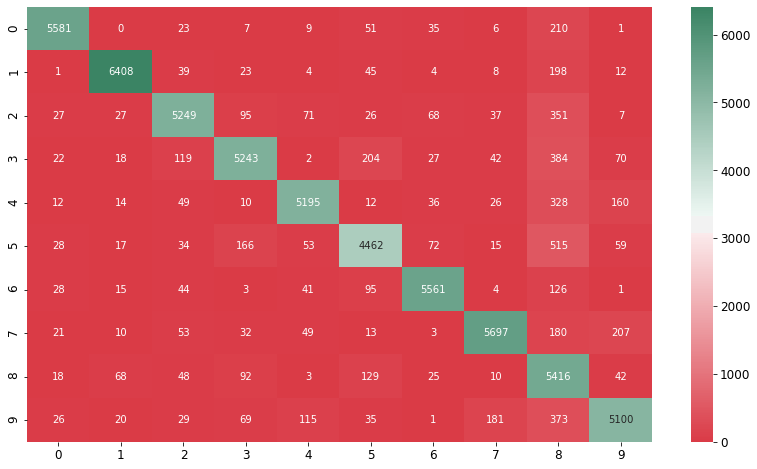

In [27]:
plt.figure(figsize=(14,8))
conf_mat_color = sns.diverging_palette(10, 150, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap=conf_mat_color)

<AxesSubplot:>

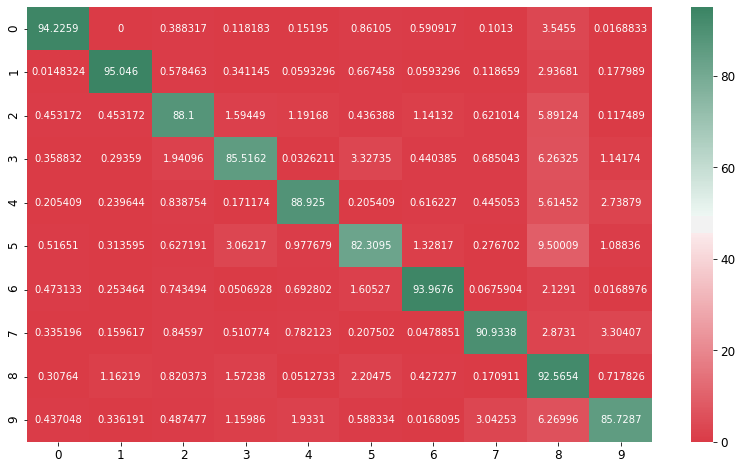

In [38]:
# Plot the accuracy
cm = confusion_matrix(y_test, y_pred)
row_sums = cm.sum(axis=1, keepdims=True)
norm_cm = (cm / row_sums) *100

plt.figure(figsize=(14,8))
sns.heatmap(norm_cm,annot=True, fmt='g', cmap=conf_mat_color)